VISUAL DATA FOR SINGLE FOLD 


>>>>>
Random Forest Algorithm 
 Best value of n for Random Forest is:               29 

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1632
           1       0.68      0.69      0.69       779
           2       0.44      0.19      0.26       163
           3       0.32      0.19      0.24        64

    accuracy                           0.77      2638
   macro avg       0.57      0.49      0.51      2638
weighted avg       0.75      0.77      0.76      2638



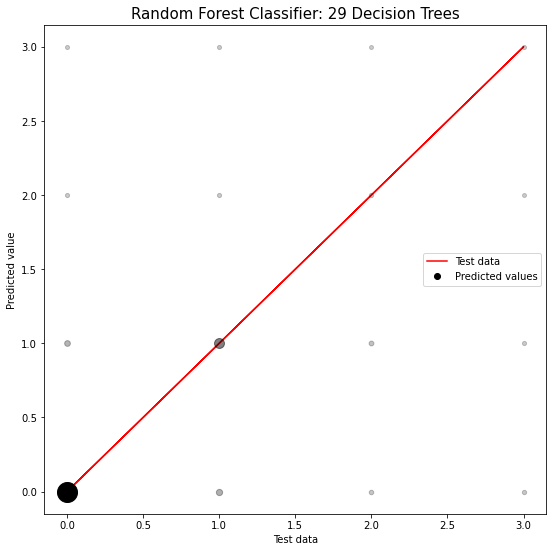


<<<<<


>>>>>
 KNN Algorithm 
 Best value of k for KNN is: 5 

              precision    recall  f1-score   support

       cubic       0.78      0.89      0.83      1632
orthorhombic       0.65      0.60      0.62       779
rhombohedral       0.39      0.13      0.20       163
  tetragonal       0.45      0.14      0.21        64

    accuracy                           0.74      2638
   macro avg       0.57      0.44      0.47      2638
weighted avg       0.71      0.74      0.72      2638



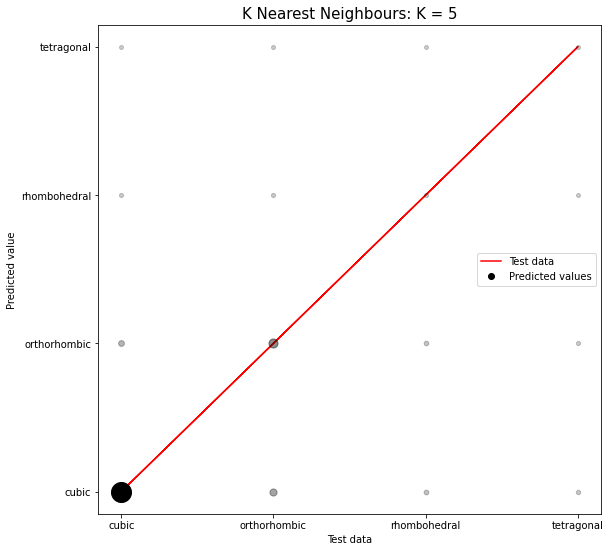


<<<<<


>>>>>
 Multinomial Logistic Regression report 

              precision    recall  f1-score   support

       cubic       0.82      0.44      0.58      1632
orthorhombic       0.47      0.52      0.49       779
rhombohedral       0.12      0.43      0.19       163
  tetragonal       0.12      0.62      0.20        64

    accuracy                           0.47      2638
   macro avg       0.38      0.50      0.37      2638
weighted avg       0.66      0.47      0.52      2638



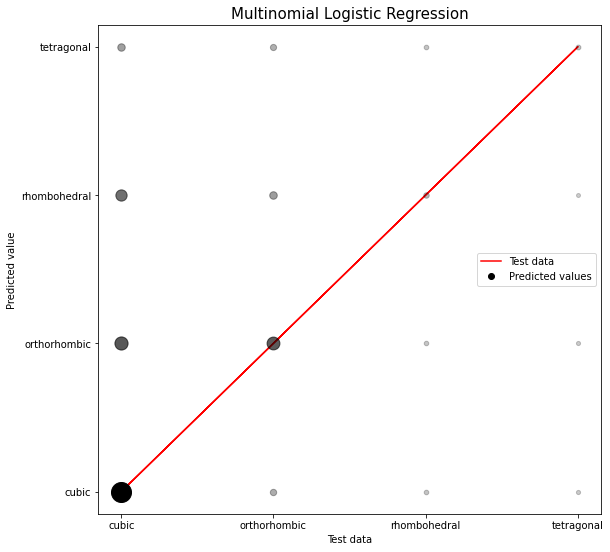


<<<<<

STRATIFIED CROSS VALIDATION USING 10 FOLDS ... 

{'RandomForest': (0.7898079466390662, 0.5673158726547183, 0.7788280302997718), 'KNN': (0.7577673078028866, 0.5276615836789361, 0.7394960040753391), 'Logistic': (0.47650904203323563, 0.36825066317652905, 0.5225048836526339)}


In [19]:
%run Preprocessing.ipynb


def KNN(data: tuple, show_graph: bool = True) -> tuple: 
    """post-test note: KNN regression for this exact data is slightly unreliable, since the data is imbalanced.
       
       K nearest neighbours algorithm that classifies the test data and returns the classifier with the best
       value of K
        Inputs:
        data: tuple of train and test data for both dependent and independent variables
        
        Returns:
        tuple of KNeighborsClassifier object of the classifier with the highest f1 score and the metrics report in
        the format of a dictionary"""
    
    # unpack the split data
    X_train, X_test, y_train, y_test = data
    
    
    # find an appropriate number to use for k
    # go through knn algorithm for different k to find the best value of k between 1 and a limit
    limit = int(math.sqrt(len(y_test)))
    
    regressor_dict = {}
    
    for k in range(limit): # we must only use odd numbers so 2k+1 will be used as index
        # initate knn and fit classifier to the data:
        classifier = knn(n_neighbors = (2*k)+1, p=2, metric = "euclidean")
        classifier.fit(X_train, y_train)
        
        # predict y for test data and compare to real y data:
        y_pred = classifier.predict(X_test)
        score = metrics.f1_score(y_test, y_pred, average = "weighted")
        
        # add classifier with their score into dictionary
        regressor_dict[classifier] =  score

    # return the key with the highest value:
    best_classifier = max(regressor_dict, key=regressor_dict.get)
    best_k = best_classifier.n_neighbors
    
    # re-predict y and collect a general metric report in dictionary format
    best_y_pred = best_classifier.predict(X_test)
    report = metrics.classification_report(y_test, best_y_pred, output_dict = True)
    
    if(show_graph == True):
        print(f"\n>>>>>\n KNN Algorithm \n Best value of k for KNN is: {best_classifier.n_neighbors} \n")
        
        # print general metric report in string format
        print(metrics.classification_report(y_test, best_y_pred))

        # Visualise the deviation of predicted data from real data
        VisualisePrediction(y_test, best_y_pred, f"K Nearest Neighbours: K = {best_k}" ,alpha_min = 0.2)
    
        print(f"\n<<<<<\n")
    
    return best_classifier, report
    


def Logistic(data: tuple, show_graph: bool = True) -> tuple:
    """post-test note: Performes slightly worse than KNN, with the lowest f1 score
       
       Multinomial logsitic regression that classifies the test data and returns the classifier
        Inputs:
        data: tuple of train and test data for both dependent and independent variables
        
        Returns:
        tuple of LogisticRegression object of the classifier and the metrics report in the 
        format of a dictionary"""
    
    # unpack the split data
    X_train, X_test, y_train, y_test = data

    # initiallise a multinomial logistic regression and fit to training set
    classifier = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000) 
    classifier.fit(X_train, y_train)

    # calculate prediction and collect a general metric report in dictionary format
    y_pred = classifier.predict(X_test)
    report = metrics.classification_report(y_test, y_pred, output_dict = True)
    
    if(show_graph == True):
        print("\n>>>>>\n Multinomial Logistic Regression report \n")
        
        # print general metric report in string format
        print(metrics.classification_report(y_test, y_pred))

        # Visualise the deviation of predicted data from real data
        VisualisePrediction(y_test, y_pred, "Multinomial Logistic Regression", alpha_min = 0.2)

        print(f"\n<<<<<\n")
    
    return classifier, report
    

def RandomForest(data: tuple, n_limit: int = 50, show_graph: bool = True) -> tuple:
    """post-test note: Performes the best out of all classifiers, with a good f1 score
       
       Random Forest algorithm that averages betweeen n_estimators decision trees.
        Inputs:
        data: tuple of train and test data for both dependent and independent variables
        n_limit: limit to the number of decision trees tested for the classification
        
        Returns:
        tuple of RandomForestClassifier object of the classifier and the metrics report
        in the format of a dictionary"""
    
    # unpack the split data
    X_train, X_test, y_train, y_test = data
    
    # Random Forest requires y values to be encoded, so we will encode it.
    # recombine y split
    y_combined = pd.concat([y_train, y_test], axis = 0)
    
    # use quick label encoding for combined y
    categories = sorted(set(y_combined))         
    category_map = {categories[i] : i for i in range(len(categories))}        
    y_combined = y_combined.apply(lambda x: category_map[x])
    
    # resplit y into train and test
    y_train = y_combined[:len(y_train)]
    y_test = y_combined[len(y_train):]
    
    regressor_dict = {}
    
    # find an appropriate number to use for n_estimators
    for n_estimators in range(n_limit):
        # for each n_estimators, classify data
        classifier = randForest(n_estimators = n_estimators + 1, criterion = 'entropy', random_state = 200)
        classifier.fit(X_train, y_train)

        # calculate prediction and get score
        y_pred = classifier.predict(X_test)
        score = metrics.f1_score(y_test, y_pred, average = "weighted")
        
        # add classifier with their score into dictionary
        regressor_dict[classifier] =  score

    # return the key with the highest value:
    best_classifier = max(regressor_dict, key=regressor_dict.get)
    best_n = best_classifier.n_estimators
    
    # re-predict y and collect a general metric report in dictionary format
    best_y_pred = best_classifier.predict(X_test)
    report = metrics.classification_report(y_test, best_y_pred, output_dict = True)
    
    if(show_graph == True):
        print(f"\n>>>>>\nRandom Forest Algorithm \n Best value of n for Random Forest is: \
              {best_classifier.n_estimators} \n")
        
        # print general metric report in string format
        print(metrics.classification_report(y_test, best_y_pred))

        # Visualise the deviation of predicted data from real data
        VisualisePrediction(y_test, best_y_pred, f"Random Forest Classifier: "
                            f"{best_n} Decision Trees", alpha_min = 0.2)
    
        print(f"\n<<<<<\n")
    
    return best_classifier, report

    
def VisualisePrediction(y_test: pd.Series, y_pred: pd.Series, classifier_name: str, alpha_min: float = 0.5,) -> None:
    """Visualises prediction of classification algorithm by comparing the real value of the
       dependant variable with the one predicted by the algorithm and plotting the deviation
       of one from the other. Plots the points as a density map, with higher number of points 
       for a coordinate being darker and larger.
        Inputs: 
        y_test: pandas series of the real values of the dependent variable.
        y_pred: pandas series of the predicted values of dependent variable.
        classifier_name: the name of classifier used to generate y_pred. Used as the title of the plot.
        alpha_min: float of the minimum alpha value for the density plot.
        
        Returns: None"""
    
    # create dataframe of y_test and y_pred
    data = pd.DataFrame({"test": y_test, "pred": y_pred})
    
    count_dict = {}
    # go through each category present in test data:
    for test_category in set(data["test"]):
        # go through each category in predicted data:
        for pred_category in set(data["pred"]):
            # get a dataframe with only occurances of a specific coordinate, 
            # and find the number of occurances of this coordinate
            coordinate_data = data[(data["test"] == test_category) & (data["pred"] == pred_category)]
            no_occurances = len(coordinate_data)
            
            # add coordinate with their count into a dictionary
            count_dict[(test_category, pred_category)] = no_occurances
        
    
    # find coordinates with maximum and minimum counts
    max_key, min_key = (max(count_dict, key = count_dict.get), min(count_dict, key = count_dict.get))
    max_count, min_count = (count_dict[max_key], count_dict[min_key])
    
    # create new dataframe of unique rows, these will be our coordinates
    set_data = data.drop_duplicates(inplace = False)
    
    # set a quick min-max scaler that will scale all the counts to an alpha range
    for key in count_dict.keys():
        # first grab the value of the key
        count = count_dict[key]
        
        # then we apply a special min-max scaler using max of 1 and min of alpha_lower
        count_range = max_count - min_count
        alpha_range = 1 - alpha_min
        
        min_diff = count - min_count
        
        # compute scaled value and replace in dictionary
        alpha = (min_diff)/(count_range) * alpha_range + alpha_min
        count_dict[key] = alpha
        
    
    # create figure and axes
    fig, ax = plt.subplots(figsize = (9,9))
    
    # plot the y_test reference values into the figure
    ax.plot(y_test, y_test, "r-", label = "Test data")
    
    # plot each coordinate of the y_test - y_pred plot individually with alpha set:
    for coordinates, alpha in count_dict.items():
        test, pred = (coordinates[0], coordinates[1])
        ax.plot(test, pred, "ko", alpha = alpha, markersize = 20*alpha)
    
    # set title and labels
    ax.set_title(classifier_name, fontsize = 15)
    ax.set_ylabel("Predicted value")
    ax.set_xlabel("Test data")
    
    # create empty line for legend
    ax.plot(0, 0, "ko", label = "Predicted values")
    
    # show legend and figure
    ax.legend()
    plt.show()


def CrossValidate(split_data: tuple, classifiers: dict) -> dict:
    """Runs several classifiers for k different folds. f1 scores for average, weighted
       and accuracy are averaged through all folds, returning a single of each score for
       each classifier
        Inputs:
        split_data: tuple containing k different train-test tuples
        classifiers: tuple containing different classifiers to be used 
        
        Returns: dictionary of name of classifier to their f1 scores stored in a tuple, where:
                0: accuracy score, 1: macro average score, 2: weighted average score."""
    
    classifier_scores = {}

    # find the average 
    for classifier in classifiers:
        
        # make empty lists of different scores to append for each fold
        classifier_f1_macro = []
        classifier_f1_weighted = []
        classifier_f1_accuracy = []

        # unpack fold into index and train-test tuple
        for i, fold in enumerate(split_data):
            # run classifier algorithm and return score measures
            # print(f"\nFOLD {i + 1}\n")
            classifier_obj, report_dict = classifier(fold, show_graph = False)
            
            # find accuracy score and add it into list
            classifier_f1_accuracy.append(report_dict["accuracy"])

            # find macro and weighted scores
            macro_scores = report_dict["macro avg"]
            weighted_scores = report_dict["weighted avg"]

            # from these scores, add f1 score to list
            classifier_f1_macro.append(macro_scores["f1-score"])
            classifier_f1_weighted.append(weighted_scores["f1-score"])

        # average the scores for all categories
        classifier_accuracyAverage = sum(classifier_f1_accuracy)/len(classifier_f1_accuracy)
        classifier_macroAverage = sum(classifier_f1_macro)/len(classifier_f1_macro)
        classifier_weightedAverage = sum(classifier_f1_weighted)/len(classifier_f1_weighted)

        # add all averaged scores into classifier score with key being name of classifier
        classifier_scores[classifier.__name__] = (classifier_accuracyAverage, \
                                                  classifier_macroAverage, classifier_weightedAverage)

    return classifier_scores
    


# make tuple of classifiers to use (if defined above) 
classifiers = (RandomForest, KNN, Logistic)

print(f"VISUAL DATA FOR SINGLE FOLD \n")
# we first run only one fold of data using conventional train/test split. This split will be visualised in a graph
for classifier in classifiers:
    classifier(split_data)
print(f"STRATIFIED CROSS VALIDATION USING {len(k_folds)} FOLDS ... \n")   
# run cross validation and store dictionary of classifiers with their f1 scores after k folds have been averaged
score_dictionary = CrossValidate(k_folds, classifiers)

print(score_dictionary)

# for score dictionary, each key is a classifier with its values being a tuple where:
# 0: average score, 1: macro average score, 2: weighted average score.